# Eine fiktive Milonga

In einer Milonga gibt es 7 Männer und 5 Frauen. Die Teilnehmer kennen sich alle untereinander und haben bestimmte Präferenzen für Tanzpartner, die in dem Datensatz `dance` beschrieben sind. Finden Sie die beste Zuordnung von Tanzpaaren, so die Gesamtzufriedenheit aller Paare maximal ist (gemessen als die Summe der erfühlten Präferenzen).

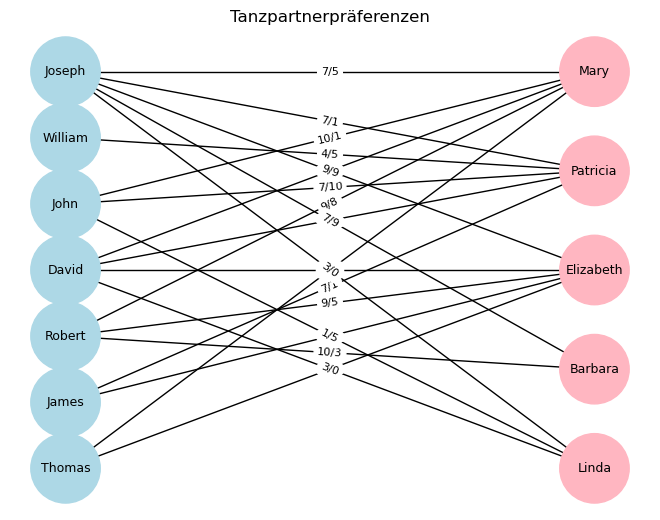

In [1]:
#| label: fig-milonga
#| fig-cap: Tanzpartnerpräferenzen

import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(122)

# Generate random names for men and women
male_names = ["John", "Michael", "David", "James", "Robert", "William", "Joseph", "Charles", "Thomas"]
female_names = ["Mary", "Patricia", "Jennifer", "Linda", "Elizabeth", "Barbara", "Susan"]

# Create a bipartite graph
B = nx.Graph()

men_n = 7
women_n = 5

# Add nodes for men and women
men = random.sample(male_names, men_n)  # Randomly select 7 male names
women = random.sample(female_names, women_n)  # Randomly select 5 female names

B.add_nodes_from(men, bipartite=0)  # Add men to one set
B.add_nodes_from(women, bipartite=1)  # Add women to the other set

# Ensure every man is connected to at least one woman
edges = [(man, random.choice(women)) for man in men]

# Ensure every woman is connected to at least one man
edges += [(random.choice(men), woman) for woman in women]

# Add additional random edges to make the graph more connected
additional_edges = [
    (random.choice(men), random.choice(women)) for _ in range(men_n + women_n - 1)
]
edges += additional_edges

# Add edges to the graph with two sets of random weights
for edge in edges:
    B.add_edge(edge[0], edge[1], menPref=random.randint(0, 10), womenPref=random.randint(0, 10))  # Assign two random weights

# Draw the bipartite graph
pos = nx.drawing.layout.bipartite_layout(B, men)  # Position nodes in two layers
nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=["lightblue" if node in men else "lightpink" for node in B.nodes()],
    node_size=2500,  # Increase node size to fit names
    font_size=9  # Reduce font size of the names
)

# Draw edge labels to show both preferences
edge_labels = nx.get_edge_attributes(B, 'menPref')
edge_labels2 = nx.get_edge_attributes(B, 'womenPref')

# Combine both weights into a single label for display
combined_labels = {edge: f"{edge_labels[edge]}/{edge_labels2[edge]}" for edge in edge_labels}
nx.draw_networkx_edge_labels(B, pos, edge_labels=combined_labels, font_size=8)

plt.title("Tanzpartnerpräferenzen")
plt.show()

Unsere Aufgabe ist, die Mitarbeiter so zuzuweisen, daß die Gesamteffizienz maximiert wird.


Der Datensatz `dt` enthält die Präferenzen der Männer und der Frauen. Der Index des Datensatzes ist zwei-dimensional, wobei die erste Dimension den Namen des Mannes und die zweite Dimension den Namen der Frau enthält. Die Spalten `womenPref` und `menPref` enthalten die Präferenzen der Frauen und der Männer

In [2]:
# Convert the graph to a pandas dataframe

import pandas as pd

dt = nx.to_pandas_edgelist(B).rename(columns = {"source": "men", "target": "women"})
dt.set_index(["men", "women"], inplace = True)
# Display the dataframe

dt["pref"] = dt["menPref"] + dt["womenPref"]
dt

menPref  womenPref  pref
men     women                              
Thomas  Elizabeth        6          1     7
        Mary             3          6     9
James   Patricia         7          1     8
        Elizabeth        2          2     4
Robert  Barbara         10          3    13
        Elizabeth        9          5    14
        Mary             9          8    17
David   Mary             0          3     3
        Linda            3          0     3
        Elizabeth        4          4     8
        Patricia         3          3     6
John    Patricia         7         10    17
        Linda            1          5     6
        Mary            10          1    11
William Patricia         4          5     9
Joseph  Barbara          7          9    16
        Linda            3          0     3
        Patricia         7          1     8
        Mary             7          5    12
        Elizabeth        9          9    18

## Das Modell

## Mengen

$i \in M = \{1, \ldots, 7\}$: Menge der Männer

$j \in W = \{1, \ldots, 5\}$: Menge der Frauen

## Parameter

$prefMen_{ij} \in \mathbb{R}$: Präferenz des Mannes $i$ für die Frau $j$

$prefWomen_{ij} \in \mathbb{R}$: Präferenz der Frau $j$ für den Mann $i$

## Variablen

$pair_{ij} \in \{0, 1\}$: 1, falls Mann $i$ mit Frau $j$ ein Paar bildet, 0 sonst

## Zielsetzung

\begin{equation}
\max \sum_{i \in M} \sum_{j \in W} (prefMen_{ij} + prefWomen_{ij}  ) \cdot pair_{ij}
\end{equation}

## Nebenbedingungen

Jeder Man bildet ein Paar mit höchstens einer Frau:

\begin{equation}
\sum_{j \in W} pair_{ij} \leq 1 \quad \forall i \in M
\end{equation}

Jede Frau bildet ein Paar mit höchstens einem Mann:

\begin{equation}
\sum_{i \in M} pair_{ij} \leq 1 \quad \forall j \in W
\end{equation}





In [30]:
dt.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [95]:
dt.index.levels[1]

Index(['Barbara', 'Elizabeth', 'Linda', 'Mary', 'Patricia'], dtype='object', name='women')

In [108]:
dt.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [ ]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model('Tanzpaare')
# m.Params.LogToConsole = 0

# Create variables

x = m.addVars(dt.index, vtype=GRB.BINARY, name="pair")

# Zielfunktion

m.setObjective(x.prod(dt["pref"].to_dict()), GRB.MAXIMIZE)

# Jeder Mann wird höchstens einer Frau zugewiesen

c_men = m.addConstrs((x.sum(man, '*') <= 1 for man in dt.index.levels[0]), name="Mann")

c_women = m.addConstrs((x.sum('*', woman) <= 1 for woman in dt.index.levels[1]), name="Frau")

m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 12 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x36f8f191
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 37.0000000
Presolve removed 4 rows and 9 columns
Presolve time: 0.00s
Presolved: 8 rows, 11 columns, 22 nonzeros
Found heuristic solution: objective 40.0000000
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 6.000000e+01, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

In [110]:
# Lösung ausgeben als pandas DataFrame

solution = pd.DataFrame(columns=["Paar"], index=dt.index)
for pair in x.keys():
    if x[pair].x > 0.5:
        solution.loc[pair] = 1
    else:
        solution.loc[pair] = 0

solution["Paar"].sum()

5

In [111]:
sol = solution.reset_index()

sol["IsDancing"] = sol.groupby("men")["Paar"].transform("sum")
sol[sol["IsDancing"] == 0]["men"].unique()

array(['James', 'William'], dtype=object)

In [112]:
m.write('Tanzpaare.lp')

with open('Tanzpaare.lp', 'r') as f:
    print(f.read())


\ Model Tanzpaare
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  7 pair[Thomas,Elizabeth] + 9 pair[Thomas,Mary] + 8 pair[James,Patricia]
   + 4 pair[James,Elizabeth] + 13 pair[Robert,Barbara]
   + 14 pair[Robert,Elizabeth] + 17 pair[Robert,Mary] + 3 pair[David,Mary]
   + 3 pair[David,Linda] + 8 pair[David,Elizabeth] + 6 pair[David,Patricia]
   + 17 pair[John,Patricia] + 6 pair[John,Linda] + 11 pair[John,Mary]
   + 9 pair[William,Patricia] + 16 pair[Joseph,Barbara]
   + 3 pair[Joseph,Linda] + 8 pair[Joseph,Patricia] + 12 pair[Joseph,Mary]
   + 18 pair[Joseph,Elizabeth]
Subject To
 Mann[David]: pair[David,Mary] + pair[David,Linda] + pair[David,Elizabeth]
   + pair[David,Patricia] <= 1
 Mann[James]: pair[James,Patricia] + pair[James,Elizabeth] <= 1
 Mann[John]: pair[John,Patricia] + pair[John,Linda] + pair[John,Mary] <= 1
 Mann[Joseph]: pair[Joseph,Barbara] + pair[Joseph,Linda]
   + pair[Joseph,Patricia] + pair[Joseph,Mary] + pair[Joseph,Elizabet